### Reading raw data 

In [1]:
from pandas import read_parquet, read_csv, DataFrame
from pathlib import Path

# TODO: Move url to config file
url: str = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-12.parquet"
df: DataFrame = read_parquet(path=url)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,14.50,3.00,0.5,0.0,0.00,0.3,18.30,2.5,None
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.00,1.0,N,145,145,2,2.50,0.50,0.5,0.0,0.00,0.3,3.80,0.0,None
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.40,1.0,N,138,25,1,28.50,0.50,0.5,10.0,0.00,0.3,39.80,0.0,None
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.60,1.0,N,161,237,2,9.00,3.00,0.5,0.0,0.00,0.3,12.80,2.5,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-31 23:56:29,2020-01-01 00:11:17,NaN,2.82,NaN,None,143,141,0,18.95,2.75,0.0,0.0,0.00,0.3,22.00,NaN,None
6896313,2,2019-12-31 23:11:53,2019-12-31 23:30:56,NaN,3.75,NaN,None,148,246,0,22.45,2.75,0.0,0.0,0.00,0.3,25.50,NaN,None
6896314,2,2019-12-31 23:57:21,2020-01-01 00:23:34,NaN,6.46,NaN,None,197,205,0,34.86,2.75,0.0,0.0,0.00,0.3,37.91,NaN,None
6896315,2,2019-12-31 23:37:29,2020-01-01 00:28:21,NaN,5.66,NaN,None,90,74,0,36.45,2.75,0.0,0.0,0.00,0.3,39.50,NaN,None


In [2]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

## Business use case analysis 

Business use case requires building an ML solution that users could interact with to obtain trip price estimates. In order to achieve that, the following assumptions were introduced:

### Assumption 1

If time of the day, distance and duration are fixed while trip start and finish zones vary - no matter the combination, price remains the same

### Assumption 2

__Users interact with web app real time__

We must only use information that is available at prediction time which takes places __before__ the trip.

The following list of available columns within the dataset:

- _VendorID_ - `A code indicating the TPEP provider that provided the record.` Given this description in metadata it's safe to assume that neither user, nor TLC can provide such information to the model
- _tpep_pickup_datetime_ - `The date and time when the meter was engaged.` We can't know that exactly, but a modified version of it, like `hour_of_the_day`, `day_of_the_week`, `is_weekend`, `is_weekday` can be extracted by asking user to select day of week he/she expects to take a taxi and roughly at what hour (e.g. morning, during the day, evening, night, etc). All of the features listed above can be then extracted easily and used at inference
- _tpep_dropoff_datetime_ - `The date and time when the meter was disengaged.` We can't know it before the trip as well as at inference time. There should be a separate ML model that estimates trip duration and then the final model that predicts the trip price should input that since trip price definetely depends on trip duration as mentioned [here](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)
- _Passenger_count_ - `The number of passengers in the vehicle. This is a driver-entered value.` According to the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page `There is no charge for extra passengers, luggage or bags, or paying by credit card.` hence we can ignore this column
- _Trip_distance_ - `The elapsed trip distance in miles reported by the taximeter.` We can't know that at prediction time. Having said that, we can have a separate service that calculates the expected distance between two locations. This can be as simple as [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) or even something more advanced and accurate like expected driveable distance calculated by distance matrix APIs provided by navigation systems or Big Tech Companies like Google (https://developers.google.com/maps/documentation/distance-matrix/overview), Microsoft (https://www.microsoft.com/en-us/maps/distance-matrix), etc. Microsoft is free for the [first 150k requests](https://www.microsoft.com/en-us/maps/create-a-bing-maps-key) and this dataset contains only 30k+ unique pickup / dropoff location pairs. So if we precalculate driveable distance and cache it for most common pickup/dropoff locations and called these API for longtail locations, we could implement this relatively cheaply.
- _PULocationID_ - `TLC Taxi Zone in which the taximeter was engaged.` User can provide this as an input to the app.
- _DOLocationID_ - `TLC Taxi Zone in which the taximeter was disengaged.` Same as with `PULocationID`, user can provide it.
- _RateCodeID_ - `The final rate code in effect at the end of the trip. 1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride;` It seems that there should be a way to infer rate from pickup / dropoff locations as well as from expected route of the trip, but this is rather difficult. On top of that, `https://www.nyc.gov/site/tlc/passengers/taxi-fare.page` states that extra passengers don't introduce addtional charges so not sure what `6=Group ride` actually means here. To avoid making things overly complicated, I'll assume that we can't know this at prediction time.
- _Store_and_fwd_flag_ - `This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip; N= not a store and forward trip;` Given this defintion, it's just irrelevant to us.
- _Payment_type_ - `A numeric code signifying how the passenger paid for the trip. 1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip;`. According the https://www.nyc.gov/site/tlc/passengers/taxi-fare.page `There is no charge for extra passengers, luggage or bags, or paying by credit card.` Plus we can't know how things will play out (e.g. whether there gonna be a dispute) before the trip, hence we can't use it in modelling.
- _Fare_amount_ - `The time-and-distance fare calculated by the meter.` This should be the target we train the model on in case we split the problem into predicting base fare price and resolving applicables taxes for the trip separately (ML estimates price, a separate service retrieves applicable taxes and fees that are added together with base price estimation).
- _Total_amount_ - `The total amount charged to passengers. Does not include cash tips.` _Total_amount_ - _Tip_amount_ is going to be the target for the first baseline model that predicts price after taxes minus tips. A more advanced approach of splitting into base price estimation + resolving taxes introduces additional complexity and first, a baseline model needs to be built in order to keep track and measure each return on investment of each iteration listed out below.
- _Tip_amount_ - `Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.`. This should be subtracted from the `total_amount` in the baseline model

Ideally, this problem should be split into 2 components:
1. Coming up with a service that resolves and fetches applicable taxes / charges for the trip. Most of the taxes can be resolved with simple if-else statements as seen [here](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page). Though there are a couple of exceptions: 
- `congestion_surcharge` is a bit problematic, even though we know exactly if-else rules when this charge is applied, yet we can't know if it's going to be applied at the end of the trip due to its nature. According https://www.nyc.gov/site/tlc/passengers/taxi-fare.page fee only applies if trip begins, ends or passes through Manhattan south of 96th Street.
- `tolls_amount` is also tricky since can't know at inference time what route the taxi driver will take. We can only get a better understanding once we start taking into account expected driveable distance and expected route of the driver. Same Google and Microsoft distance matrix APIs could help us a lot with that.
2. Predicting base trip price before taxes + congestion_surcharge + tolls_amount with machine learning. We can't use if-else statement to figure out exactly what base price and two of the fees are going to be. We can only predict this given historical data we have at our disposal.

Finally results of part 1 and 2 should be added together and its output will be our expected trip price after taxes which should be more accurate than just blindly trying to predict price after taxes.

These are charges that we can infer easily at prediction time with if-else statements:
- Extra - `Miscellaneous extras and surcharges. Currently, this only includes the \\$0.50 and \\$1 rush hour and overnight charges.`
- MTA_tax - `\\$0.50 MTA tax that is automatically triggered based on the metered rate in use.`. There is a location metadata file available at `./data/taxi_zone_lookup.csv` that can help us to infer if dropoff location is eligible for MTA_tax
- Improvement_surcharge - `\\$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.`
- Airport_fee - `$1.25 for pick up only at LaGuardia and John F. Kennedy Airports`

### Potential baseline model ideas and further iterations to improve it

At the very top are ideas that require least effort, but their expected quality of the predictions should in turn be least accurate. Each addition of more complexity to the system / solution should only come once there is an established baseline model that could be used a reference point in order to measure progress and improvements on price estimatates. Furthermore, it setups the whole project in a way that makes it easier to evaluate return on investment with each progression. At some point, costs of improving model even slightly can outweight gains. Having a strong baseline and trying to improve on top in this manner helps to catch these moments and rather focus on something that bring more value (projects with better ROIs). With that being said, in this project I'll focus on building a baseline model. Below are seen other ideas / hypotheses that might be worth looking into in order to improve accuracy of the price estimates:

1. Build a very basic baseline trip price estimation model from pickup and dropoff location_ids, time while predicting _Total_amount_ - _Tip_amount_ which is price after taxes without tips (to avoid that hassle of dealing with taxes mentioned above). 
2. Extend the baseline model where instead of pickup / dropoff location_ids, metadata from `./data/taxi_zone_lookup.csv` is joined and used instead to represent locations (e.g. instead of `PULocationID`, `borough`, `zone` and `service_zone` are used). Metadata is less granular and contains more data points per category which should lead to more stable predictions and less overfitting in general (also more interactions betweeen features that model might pickup in training).
3. Improve model from above by separating taxes from trip price estimation since simple if-else statements are enough to know most of the applicable taxes / charges (with exception of `congestion_surcharge` and `total_tolls`, these need to be modeled together with base trip price estimatation). The price prediction problem is then split into two: building a model to predict `fare_amount + congestion_surcharge + total_tolls` and building separate service for retrieving applicable fees that would be added on top of previous predictions. Only things that we don't know how to write a program for (e.g. if-else conditions) should be modeled with ML, otherwise it needs to solved by writing traditional software. First part only requires ML, the rest - not.
4. At this point we can start adding more complex features to `Fare_amount + congestion_surcharge + total_tolls` predictions as everything else doesn't not even rely on ML. Features like expected driveable distance between two zones (no need for ML, e.g. Microsoft Bing Maps distance matrix API should suffice it `https://www.microsoft.com/en-us/maps/distance-matrix` which is free for the first 150k requests) and estimated_trip_duration should greatly improve base trip price accuracy. It's strongly hinted in https://www.nyc.gov/site/tlc/passengers/taxi-fare.page (under _Standard Metered Fare_) that these two signals are what basically drives base fare prices ("Plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped."). A distance calculated by the [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) can complement already proposed feature set as well.
5. We could then instead ask users on the web app to enter exact pickup / dropoff address and we could map both addresses to exact coordinates, improve accuracy of expected driveable distance and trip duration estimates and in turn - base price predictions.

### Important notes 

- At some point we should introduce quantile regression to estimate not only price and but also it's confidence intervals. Narrow intervals would indicate that model is confident in making its prediction (might be due to many examples available in training data) and wide the opposite - model is not confident and lack of training examples for such trips might be a reason behind it. In that case we would know what data we would need collect in the future in order to improve model performance. Bare point estimates without confidence intervals don't really mean a lot since you don't know how confident the model is in making each estimation.
- Also for more robust model performance, confidences interval estimates its better to use [time series cross validation](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4). Due to time constraints, I'll use a special case of cross validation with just 1 fold.
- Metrics for model evaluation: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) and [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error). `RMSE` punishes bad predictions for high prices more (but it also suffers from outliers) while `MAPE` gives an idea how well model performs across the wide range of prices.

Food for thought:
- Add features that model demand for taxis across time (e.g. high historical average trip count for specific hour of the day could indicate high demand at that time and high demand usually leads to increased rates due to [dynamic pricing](https://en.wikipedia.org/wiki/Dynamic_pricing) and in turn - final prices).
- Even though gdbt frameworks deal with categorical variables really well, embedding categories by the means of [target encoding](https://www.google.com/search?client=firefox-b-lm&q=target+encoding) technique might be a better alternative. Due to time constrains, I will not look into this. This needs to be implemented carefully in order to benefit from that and not introduce target leaking and overfitting. More links: https://brendanhasz.github.io/2019/03/04/target-encoding

### Exploration

#### Taxes

Sanity-checking if adding all taxes to `fare_amount` results in `total_amount`

In [3]:
all_tax_cols = df.iloc[:, 10:16].columns.tolist() + df.iloc[:, 17:].columns.tolist()
all_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'congestion_surcharge',
 'airport_fee']

In [4]:
expected_total = df[all_tax_cols].sum(axis=1).round(2)
actual_total = df["total_amount"].round(2)

In [5]:
(expected_total == actual_total).sum() / df.shape[0] 

0.6921363968622672

Nope. According to https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, only for some trips `congestion_surcharge` is applied. "Plus New York State Congestion Surcharge of \$2.50 (Yellow Taxi) or \$2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street."

In [6]:
no_cong_tax_cols = all_tax_cols.copy()
no_cong_tax_cols.remove("congestion_surcharge")
no_cong_tax_cols

['fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'airport_fee']

In [7]:
expected_total_2 = df[no_cong_tax_cols].sum(axis=1).round(2)

In [8]:
(expected_total_2 == actual_total).sum() / df.shape[0] 

0.3893064950465589

Need more time to figure out how to reconstruct `total_amount` from `fare_amount` and taxes. This is not a blocker for this small project though since we're focusing on predicting prices after taxes. This only becomes relevant when we start separating into base price estimation and taxes (look for iteration list above)

#### Cleaning the data

Joining pickup / dropoff location metadata

In [9]:
# TODO: Move url to the config file
location_meta_df = read_csv("~/Desktop/yellow-taxi-trip/data/taxi_zone_lookup.csv")
location_meta_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [10]:
df = (df
          .merge(location_meta_df.add_prefix("PU"), on="PULocationID")
          .merge(location_meta_df.add_prefix("DO"), on="DOLocationID"))
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,0.3,18.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,0.3,16.30,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,0.3,23.16,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,0.3,22.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,0.3,17.80,2.5,None,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896312,2,2019-12-14 15:14:00,2019-12-14 15:49:00,NaN,-9.01,NaN,None,61,2,0,...,0.3,49.20,NaN,None,Brooklyn,Crown Heights North,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896313,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,0.3,60.70,0.0,None,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896314,2,2019-12-13 20:53:26,2019-12-13 21:22:14,NaN,10.89,NaN,None,197,2,0,...,0.3,42.83,NaN,None,Queens,Richmond Hill,Boro Zone,Queens,Jamaica Bay,Boro Zone
6896315,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,0.3,72.36,0.0,None,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone


Analyzing the volume of null values

In [11]:
for col in df:
    print(col, 100*df[col].isnull().sum() / df.shape[0])

VendorID 0.0
tpep_pickup_datetime 0.0
tpep_dropoff_datetime 0.0
passenger_count 0.7397861786225894
trip_distance 0.0
RatecodeID 0.7397861786225894
store_and_fwd_flag 0.7397861786225894
PULocationID 0.0
DOLocationID 0.0
payment_type 0.0
fare_amount 0.0
extra 0.0
mta_tax 0.0
tip_amount 0.0
tolls_amount 0.0
improvement_surcharge 0.0
total_amount 0.0
congestion_surcharge 0.7397861786225894
airport_fee 100.0
PUBorough 0.0
PUZone 0.05513087637937757
PUservice_zone 0.8079094971997371
DOBorough 0.0
DOZone 0.26698308676935817
DOservice_zone 0.933527272600723


The whole `airport_fee` column is nulls, thus we can drop it

In [12]:
df.drop(columns=["airport_fee"], inplace=True)

Amount of records with nulls values is negligible, we can drop them with little downside in this project. Even if this wasn't the case, most popular gradient boosted decision tree frameworks deal with missing data. For more info:
- https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values
- https://catboost.ai/en/docs/concepts/algorithm-missing-values-processing
- https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle

__N.B.__ In real world scenarios it makes sense to reach out to data producers and ask them if those nulls should even exist and if that's the case, what do they mean, how to deal with them. Quite often missing values is a sign of an underlying bug and this should be brought to data producers attention so that they could fix it.

In [13]:
# Dropping records with at least 1 missing value
df.dropna(inplace=True)

Constructing the target for the baseline model

In [14]:
df.loc[:, "target"] = df.loc[:, "total_amount"] - df.loc[:, "tip_amount"]

Calculating trip durations

In [15]:
df["trip_duration_in_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.seconds / 60

In [16]:
df.describe().round(2)

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,target,trip_duration_in_minutes
count,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00,6761972.00
mean,1.67,1.55,2.92,1.05,163.10,160.76,1.30,13.22,1.10,0.49,2.23,0.36,0.30,19.25,2.31,17.01,18.43
std,0.47,1.18,8.26,0.80,65.61,69.87,0.49,153.68,1.25,0.06,2.75,1.62,0.03,153.91,0.69,153.76,70.18
min,1.00,0.00,-23.01,1.00,1.00,1.00,1.00,-1472.00,-4.50,-0.50,-200.80,-40.50,-0.30,-1472.80,-2.50,-1472.80,0.00
25%,1.00,1.00,0.96,1.00,125.00,107.00,1.00,6.50,0.00,0.50,0.00,0.00,0.30,11.30,2.50,10.30,6.82
50%,2.00,1.00,1.60,1.00,162.00,162.00,1.00,9.50,0.50,0.50,1.95,0.00,0.30,14.80,2.50,13.30,11.62
75%,2.00,2.00,3.00,1.00,233.00,233.00,2.00,15.00,2.50,0.50,3.00,0.00,0.30,21.00,2.50,18.30,19.25
max,2.00,9.00,19130.18,99.00,263.00,263.00,5.00,398468.38,90.06,3.30,404.44,612.66,0.30,398471.20,3.00,398471.20,1439.92


There are a bunch of weird min / max values (e.g. negative min `trip_distance`, `fare_amount`, `extra`, `tip_amount` values and incredibly large max values for `trip_distance`, `fare_amount`, `trip_duration_in_minutes`)

Text(0.5, 1.0, 'Total amount - tips distribution')

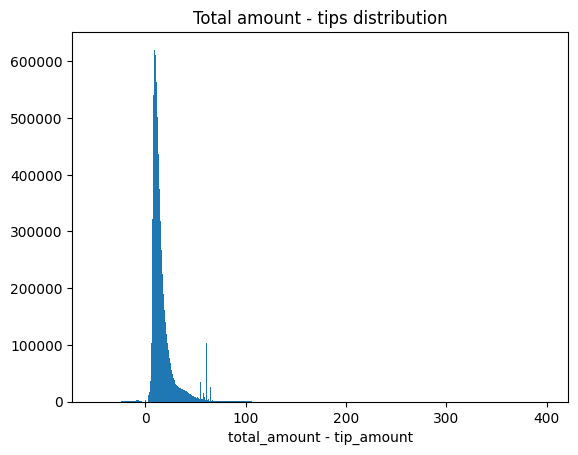

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["target"], 
         bins=np.arange(-50, 400))
plt.xlabel("total_amount - tip_amount")
plt.title("Total amount - tips distribution")

Spreading out highly concentrated results with log scale

Text(0.5, 1.0, 'Total amount - tips distribution')

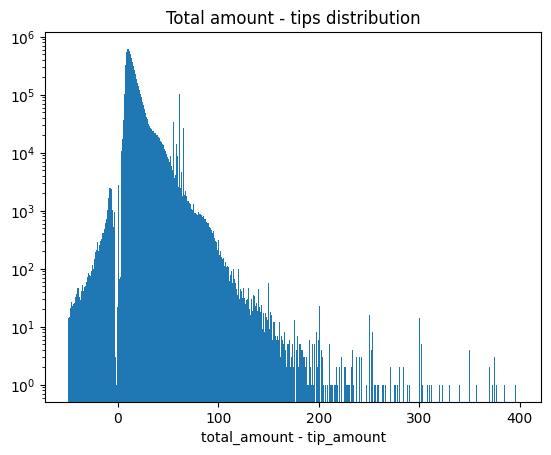

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["target"], 
         bins=np.arange(-50, 400),
         log=True)
plt.xlabel("total_amount - tip_amount")
plt.title("Total amount - tips distribution")

In [19]:
print(df["target"].min())
print(df["target"].max())

-1472.8
398471.2


There are suspiciously high and low prices. It's doubtful that somebody paid 400k for a ride with taxi as well as it's doubtful that driver paid for the trip out of his own pocket (don't know how else to interpret negative trip prices :) )
All outliers should be clipped. I chose starting point 2.50 as this is an initial charge according to https://www.nyc.gov/site/tlc/passengers/taxi-fare.page

In [20]:
# Clipping the outliers
df = df[(df["target"] > 2.50)&(df["target"] < 1000)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,target,trip_duration_in_minutes
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,18.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,18.30,14.783333
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,16.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,16.30,10.916667
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,23.16,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,19.30,16.483333
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,22.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,20.80,13.133333
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,17.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,17.80,16.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896310,2,2019-12-30 05:47:11,2019-12-30 06:17:47,1.0,12.15,1.0,N,132,2,2,...,41.88,0.0,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone,41.88,30.600000
6896311,1,2019-12-22 17:25:46,2019-12-22 18:43:49,1.0,0.00,1.0,N,68,2,1,...,65.58,0.0,Manhattan,East Chelsea,Yellow Zone,Queens,Jamaica Bay,Boro Zone,65.58,78.050000
6896313,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,60.70,0.0,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone,60.70,58.433333
6896315,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,72.36,0.0,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone,60.30,17.400000


In [21]:
print(df["tpep_dropoff_datetime"].min())
print(df["tpep_dropoff_datetime"].max())

2008-12-31 18:27:42
2090-12-31 07:18:49


Need to clip data on timestamps as well. Dataset source indicates that it's supposed to contain data from December of 2019

In [22]:
df = df[(df["tpep_dropoff_datetime"] > "2019-12-01 00:00:00")&(df["tpep_dropoff_datetime"] < "2020-01-01 00:00:00")]

Quick sanity-check on `tpep_pickup_datetime`

In [23]:
print(df["tpep_pickup_datetime"].min())
print(df["tpep_pickup_datetime"].max())

2019-11-30 17:51:55
2019-12-31 23:59:07


In [24]:
print(df["trip_duration_in_minutes"].min())
print(df["trip_duration_in_minutes"].max())

0.0
1439.9166666666667


Text(0.5, 1.0, 'Trip duration in minutes distribution')

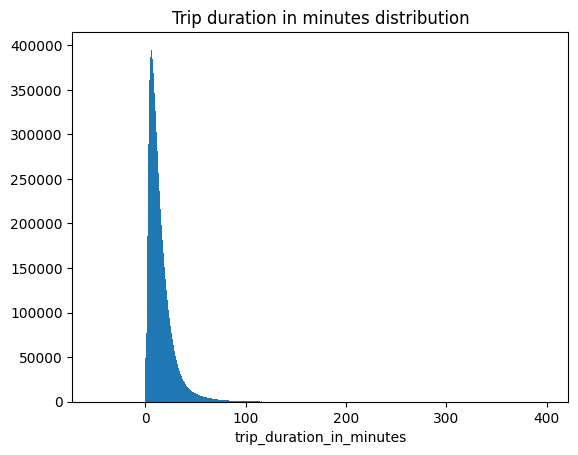

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["trip_duration_in_minutes"], 
         bins=np.arange(-50, 400))
plt.xlabel("trip_duration_in_minutes")
plt.title("Trip duration in minutes distribution")

Need to clip values on `trip_duration` as well

In [26]:
# Clipping the outliers
df = df[(df["trip_duration_in_minutes"] > 0)&(df["trip_duration_in_minutes"] < 500)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,target,trip_duration_in_minutes
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,18.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,18.30,14.783333
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,16.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,16.30,10.916667
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,23.16,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,19.30,16.483333
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,22.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,20.80,13.133333
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,17.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,17.80,16.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896310,2,2019-12-30 05:47:11,2019-12-30 06:17:47,1.0,12.15,1.0,N,132,2,2,...,41.88,0.0,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone,41.88,30.600000
6896311,1,2019-12-22 17:25:46,2019-12-22 18:43:49,1.0,0.00,1.0,N,68,2,1,...,65.58,0.0,Manhattan,East Chelsea,Yellow Zone,Queens,Jamaica Bay,Boro Zone,65.58,78.050000
6896313,1,2019-12-18 20:50:12,2019-12-18 21:48:38,1.0,0.00,1.0,N,250,2,1,...,60.70,0.0,Bronx,Westchester Village/Unionport,Boro Zone,Queens,Jamaica Bay,Boro Zone,60.70,58.433333
6896315,2,2019-12-11 23:28:07,2019-12-11 23:45:31,1.0,13.36,5.0,N,196,2,1,...,72.36,0.0,Queens,Rego Park,Boro Zone,Queens,Jamaica Bay,Boro Zone,60.30,17.400000


Text(0.5, 1.0, 'Trip distance distribution')

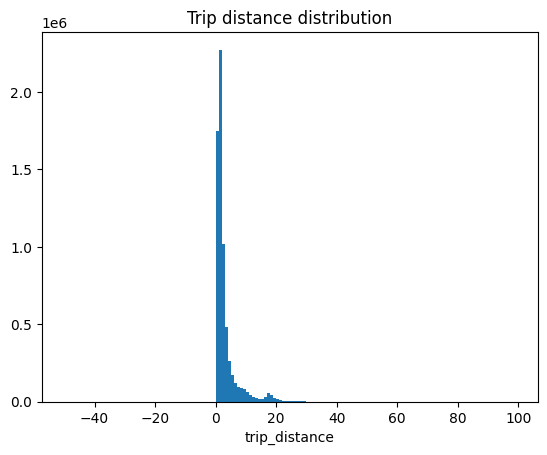

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(df["trip_distance"], 
         bins=np.arange(-50, 100))
plt.xlabel("trip_distance")
plt.title("Trip distance distribution")

In [28]:
print(df["trip_distance"].min())
print(df["trip_distance"].max())

-23.01
19130.18


In [29]:
# Clipping values on trip_distance
df = df[(df["trip_distance"] > 0)&(df["trip_distance"] < 200)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,target,trip_duration_in_minutes
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.20,1.0,N,142,116,2,...,18.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,18.30,14.783333
1,2,2019-12-01 00:03:51,2019-12-01 00:14:46,5.0,3.56,1.0,N,142,116,2,...,16.30,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,16.30,10.916667
2,2,2019-12-01 00:38:18,2019-12-01 00:54:47,1.0,4.48,1.0,N,142,116,1,...,23.16,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,19.30,16.483333
3,2,2019-12-01 01:23:23,2019-12-01 01:36:31,1.0,5.35,1.0,N,142,116,1,...,22.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,20.80,13.133333
4,2,2019-12-01 02:15:49,2019-12-01 02:32:47,1.0,4.02,1.0,N,142,116,2,...,17.80,2.5,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,17.80,16.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896307,1,2019-12-21 14:20:13,2019-12-21 14:24:45,0.0,0.60,1.0,N,195,105,1,...,6.30,0.0,Brooklyn,Red Hook,Boro Zone,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone,5.80,4.533333
6896308,2,2019-12-02 10:17:34,2019-12-02 10:37:31,1.0,9.42,1.0,N,132,2,2,...,28.30,0.0,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone,28.30,19.950000
6896309,2,2019-12-22 15:01:52,2019-12-22 15:27:12,1.0,8.67,1.0,N,132,2,1,...,34.56,0.0,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone,28.80,25.333333
6896310,2,2019-12-30 05:47:11,2019-12-30 06:17:47,1.0,12.15,1.0,N,132,2,2,...,41.88,0.0,Queens,JFK Airport,Airports,Queens,Jamaica Bay,Boro Zone,41.88,30.600000


In [30]:
print(df["passenger_count"].min())
print(df["passenger_count"].max())

0.0
9.0


Passenger count doesn't make sense, according to https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page, max capacity allowed by law for yellow taxis is either 4 or 5 depending on the type of the car.

In [31]:
df = df[(df["passenger_count"] >= 1)&(df["passenger_count"] <= 5)]

In [32]:
print(df["RatecodeID"].min())
print(df["RatecodeID"].max())

1.0
99.0


 According to https://www.nyc.gov/site/tlc/passengers/taxi-fare.page, there can only be 6 rate ids `1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride;`

In [33]:
df = df[(df["RatecodeID"] >= 1)&(df["RatecodeID"] <= 6)]

Now checking again for anything weird

In [34]:
df.describe().round(2)

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,target,trip_duration_in_minutes
count,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.00,6403420.0,6403420.0,6403420.00,6403420.00,6403420.00
mean,1.67,1.48,2.94,1.04,163.27,160.92,1.29,13.13,1.10,0.50,2.24,0.36,0.3,19.2,2.33,16.96,15.01
std,0.47,0.97,3.77,0.24,65.58,69.87,0.47,11.02,1.25,0.03,2.71,1.61,0.0,13.8,0.63,12.04,12.65
min,1.00,1.00,0.01,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,2.7,0.00,2.70,0.02
25%,1.00,1.00,0.98,1.00,125.00,112.00,1.00,6.50,0.00,0.50,0.00,0.00,0.3,11.3,2.50,10.30,6.88
50%,2.00,1.00,1.61,1.00,162.00,162.00,1.00,9.50,0.50,0.50,1.96,0.00,0.3,14.8,2.50,13.30,11.65
75%,2.00,2.00,3.00,1.00,233.00,233.00,2.00,15.00,2.50,0.50,3.00,0.00,0.3,20.8,2.50,18.30,19.18
max,2.00,5.00,163.30,6.00,263.00,263.00,5.00,700.00,90.06,3.30,404.44,612.66,0.3,720.3,3.00,700.30,499.82


Now things make sense and we can move to building a model

### Building a baseline model

Preparing time features

In [36]:
df["day_of_week"] = df["tpep_pickup_datetime"].dt.dayofweek.astype("int32")
df["hour_of_day"] = df["tpep_pickup_datetime"].dt.hour.astype("int32")

Definining config params. This needs to be moved to a proper config file.

In [37]:
# TODO: Move everything to a config file
test_start_time = "2019-12-25 00:00:00"

inputs_cols = ["day_of_week", "hour_of_day", "PUZone", "DOZone"]
target_col = "target"
grid_search_params= { "param_grid" : {"learning_rate": [0.005, 0.1, 0.15],
                                    "iterations": [300, 400, 500, 600, 700],
                                    "depth": [8, 9, 10],
                                    "has-time": [False, True]},
                      "cv": 1,
                      "partition_random_seed": 0,
                      "calc_cv_statistics": True,
                      "search_by_train_test_split": True,
                      "refit": True,
                      "shuffle": False,
                      "stratified": False,
                      "train_size": 0.8,
                      "verbose": True,
                      "plot": True
                    }

In [ ]:
train_df = df.loc[df["tpep_dropoff_datetime"] < test_start_time]
test_df = df.loc[(df["tpep_dropoff_datetime"] < test_start_time)]

For training and serving the model, I'll use gbdt family models trained with [CatBoost](https://catboost.ai/)

In [ ]:
from catboost import CatBoostRegressor
import numpy as np

train_data = np.random.randint(1, 100, size=(100, 10))
train_labels = np.random.randint(2, size=(100))

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=train_data,
                                       y=train_labels,
                                       plot=True)